In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import transforms, datasets

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # to set the device as cuda supported gpu if available

In [5]:
# transformations to use only while training of the model
transform_train = transforms.Compose([transforms.Resize((32, 32)), # to resize the image into 32 * 32 resolution
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
                                transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
                                transforms.ToTensor(), # to convert into tensor and also scale between 0 to 1
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # this normalizes the pixel values by setting mean, std = 0.5.
                                ])

# transformations to use during testing and validation
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
                                ])

training_dataset = datasets.CIFAR10(root='./data', train = True, download = True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train = False, download = True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size = 100, shuffle= True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle= True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

In [8]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() # a note on the detach function below
    image = image.transpose(1,2,0) # swaps the places of the channels, the first would be moved to last, giving is (28, 28, 1)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)) 
    image = image.clip(0, 1) # forcibly squashes the value to range between 0 and 1
    return image

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

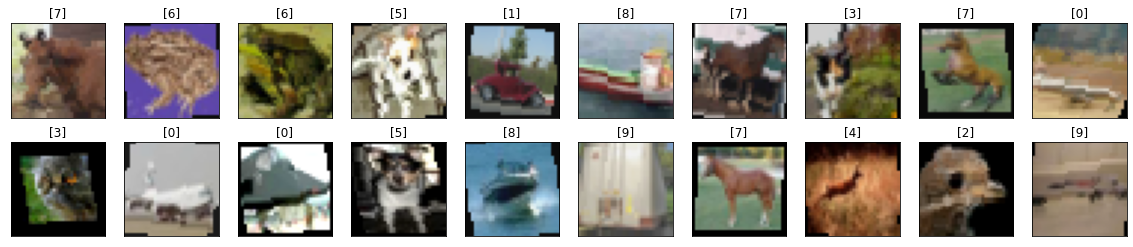

In [9]:
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

**tensor.detach()** creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

The wrapper with **torch.no_grad()** temporarily set all the ***requires_grad*** flag to false. ***torch.no_grad*** says that no operation should build the graph.

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        # adding the first two dense layers
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding = True) # 1 is the channel, 20 filters, 5 is filter size, 1 is the stride
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding = True)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding = True)
        # defining the dense layers and dropout
        self.fc1 = nn.Linear(4*4*64, 500) # the input to dense is 4*4*50 as 4*4 would be output image shape from Conv layers.
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [11]:
model = LeNet()
if torch.cuda.is_available():
    model.cuda()
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(True, True))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [13]:
epochs = 20
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

# going through each epoch
for e in range(epochs):
    running_loss = 0
    running_corrects = 0 
    val_running_loss = 0
    val_running_corrects = 0

    # going through each batch
    for inputs, labels in training_loader:
        # inputs = inputs.view(inputs.shape[0], -1) we don't need these layers as we don't need 1D array initially for Conv.
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # calculating the prediction by getting the max probability class
        _, preds = torch.max(outputs, 1)

        # adding the losses for the batches
        running_loss += loss.item()
        # adding the accuracy for the batches
        running_corrects += torch.sum(preds == labels.data)

    else:

        # calculating the same metrics as above for validation set
        with torch.no_grad():
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                # val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_running_loss += val_loss.item()
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        # calculating the epoch loss
        epoch_loss = running_loss / len(training_loader)
        # calculating the epoch accuracy
        epoch_acc = running_corrects.float() / len(training_loader)

        running_loss_history.append(epoch_loss)
        running_corrects_history.append(epoch_acc)

        # calculating epoch loss and accuracy for validation set
        val_epoch_loss = val_running_loss / len(validation_loader)
        val_epoch_acc = val_running_corrects / len(validation_loader)
        val_running_loss_history.append(val_epoch_loss)
        val_running_corrects_history.append(val_epoch_acc)
        print('Epoch: ', (e+1))
        print('Training Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch_loss, epoch_acc.item()))
        print('Validation Loss: {:4f}, Validation Accuracy: {:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

Epoch:  1
Training Loss: 1.6658, Accuracy: 38.8340
Validation Loss: 1.380849, Validation Accuracy: 49.5200
Epoch:  2
Training Loss: 1.3760, Accuracy: 50.2180
Validation Loss: 1.247843, Validation Accuracy: 55.0300
Epoch:  3
Training Loss: 1.2564, Accuracy: 55.0300
Validation Loss: 1.115613, Validation Accuracy: 60.1100
Epoch:  4
Training Loss: 1.1682, Accuracy: 58.6260
Validation Loss: 1.054373, Validation Accuracy: 62.6600
Epoch:  5
Training Loss: 1.1030, Accuracy: 60.8900
Validation Loss: 0.984358, Validation Accuracy: 64.9600
Epoch:  6
Training Loss: 1.0452, Accuracy: 63.0920
Validation Loss: 0.946056, Validation Accuracy: 67.1500
Epoch:  7
Training Loss: 1.0099, Accuracy: 64.5340
Validation Loss: 0.897748, Validation Accuracy: 68.4800
Epoch:  8
Training Loss: 0.9830, Accuracy: 65.4060
Validation Loss: 0.907260, Validation Accuracy: 68.7500
Epoch:  9
Training Loss: 0.9502, Accuracy: 66.8320
Validation Loss: 0.878965, Validation Accuracy: 69.5300
Epoch:  10
Training Loss: 0.9328, Acc

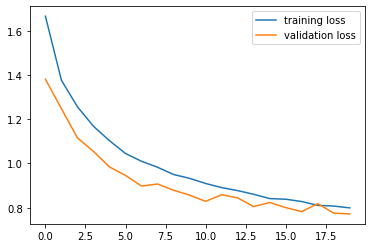

In [14]:
plt.plot(running_loss_history, label = 'training loss')
plt.plot(val_running_loss_history, label = 'validation loss')
plt.legend()
plt.show()

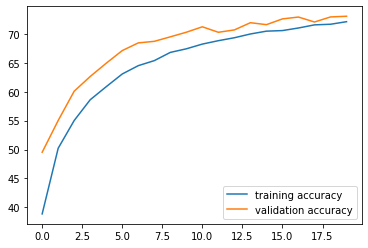

In [15]:
plt.plot(running_corrects_history, label = 'training accuracy')
plt.plot(val_running_corrects_history, label = 'validation accuracy')
plt.legend()
plt.show()

We can now try with a random image from the internet to validate out model.

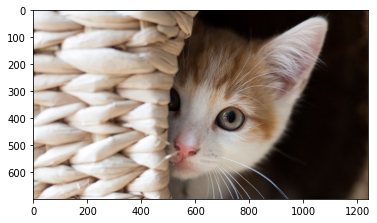

In [16]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://www.humanesociety.org/sites/default/files/styles/1240x698/public/2018/08/kitten-440379.jpg?h=c8d00152&itok=1fdekAh2'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img);

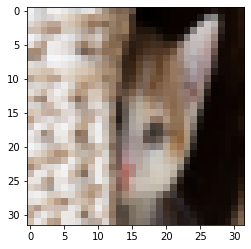

In [17]:
# We have to transform out image so be similar to the ones we have in the MNIST training set.
img = transform(img)
plt.imshow(im_convert(img))

In [23]:
# feeding it to the model and getting the output
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

cat


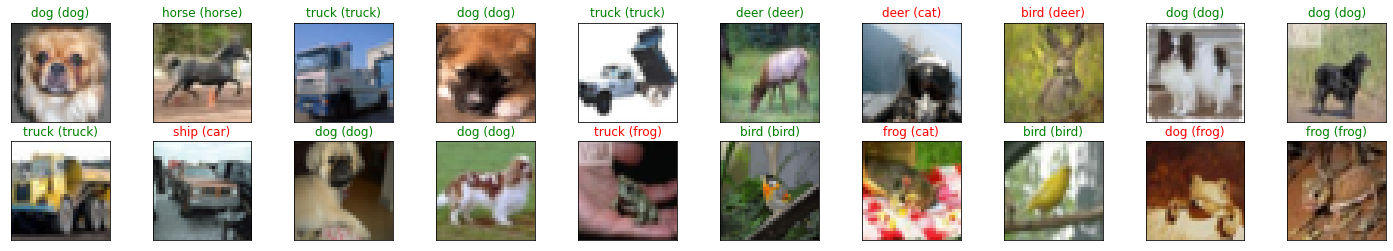

In [30]:

dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))